# Shooting Metghod for One-Dimensional Advection Equation with Damping

## Import Packages

In [5]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using Plots
using BenchmarkTools 

## Section 1: Introduction 

More later. 

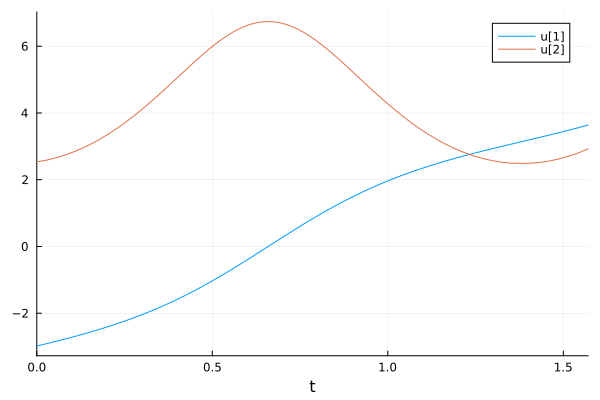

In [7]:
const g = 9.81
L = 1.0

function simplependulum!(du, u, p, t)
    θ = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g / L) * sin(θ)
end

function bc1!(residual, u, p, t)
#    residual[1] = u(pi / 4)[1] + pi / 2 # the solution at the middle of the time span should be -pi/2
#    residual[2] = u(pi / 2)[1] - pi / 2 # the solution at the end of the time span should be pi/2
    residual[1] = u(.5)[1] + 1 
    residual[2] = u(1.)[1] - 2 
end

tspan = (0.0, pi / 2)

bvp1 = BVProblem(simplependulum!, bc1!, [pi / 2, pi / 2], tspan)

sol1 = solve(bvp1, MIRK4(); dt = 0.05)

plot(sol1)

## Section 2: Advection Equation

### Section 1.2: Auxiliary Functions   

In [66]:
# set source function 
src(x) = 10*sin(pi*x) 
#src(x) = 1

# set right-hand side 
function rhs!(du, u, p, x)
    c, gamma, gamma3, omd = p 
    Ac = u[1]; Bs = u[2]
    du[1] = - gamma/c*Ac - omd/c*Bs
    du[2] = omd/c*Ac - gamma/c*Bs + src(x)/c 
end

# set boundary conditions 
function bcdirichlet!(residual, u, p, x)
    Acleft = 1; Bsleft = 0; 
    residual[1] = u(0)[1] - Acleft 
    residual[2] = u(0)[2] - Bsleft
end

# set boundary conditions 
function bcperiodic!(residual, u, p, x)
    residual[1] = u(0)[1] -  u(1)[1]
    residual[2] = u(0)[2] -  u(1)[2]
end

bcperiodic! (generic function with 1 method)

### Section 2.2: Set Parameters and Solve  

In [67]:
# set constants 
c = 1.
gamma = 5. 
gamma3 = 0  
omd = 25
p = [c, gamma, gamma3, omd]

# set domain size 
xspan = (0.,5.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bcdirichlet!, start, xspan,p)
#bvp = BVProblem(rhs!, bcperiodic!, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.05);

### Section 3.2: Post-Processing   

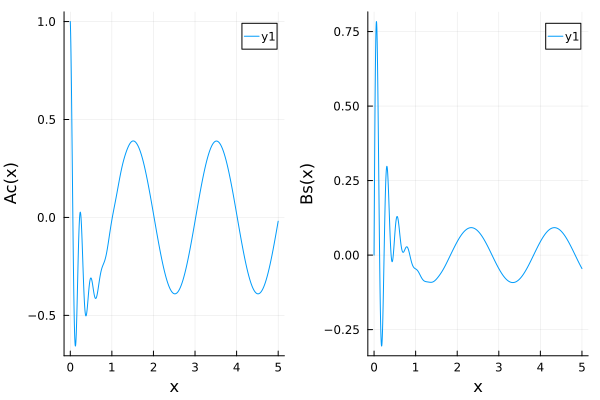

In [68]:
# plot u(x) and du/dx(x)
Ac = [u[1] for u in sol.u]
Bs = [u[2] for u in sol.u]
p1 = plot(sol.t, Ac, xlabel="x", ylabel = "Ac(x)") 
p2 = plot(sol.t, Bs, xlabel="x", ylabel = "Bs(x)") 
plot(p1,p2,layout=(1,2))

### Section 4.2: Plot solution in space-time domain 

Construct solution in time domain by outer product of two vectors, one in space, the other in time. 

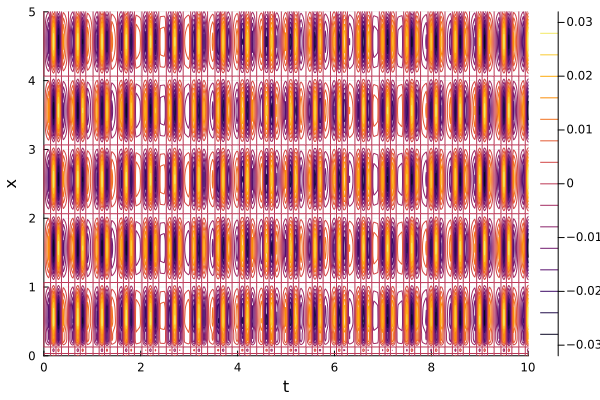

In [56]:
tend = 10; tstep = 0.1; 
tvec = 0:tstep:tend |> collect
ucost = sin.(omd*tvec)
usint = sin.(omd*tvec)
U = Ac*ucost' + Bs*usint'
contour(tvec,sol.t,U,xlabel="t",ylabel="x")

### Section 5.2: Solve ploblem for Various Frequency Values 

By adapting the [Example-2:-Solving-an-SDE-with-Different-Parameters](https://docs.sciml.ai/DiffEqDocs/stable/features/ensemble/#Example-2:-Solving-an-SDE-with-Different-Parameters). 

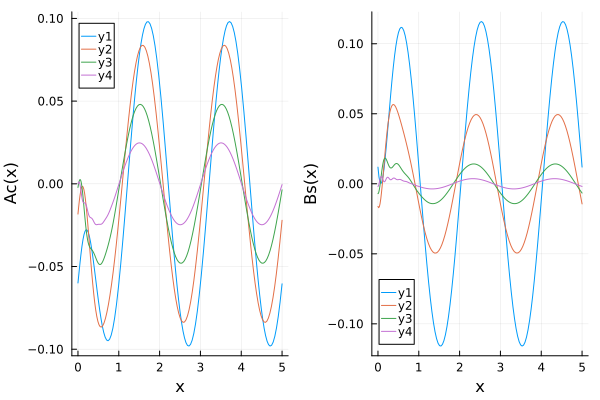

In [59]:
omdvec = [5.,10.,20.,40.]
mypltb1 = plot();
mypltb2 = plot();
for omdi in omdvec
    p2 = [c, gamma, gamma3, omdi]
    bvp = remake(bvp, p=p2);
    sol = solve(bvp, MIRK4(), dt = 0.05);
    Ac  = [u[1] for u in sol.u]
    Bs  = [u[2] for u in sol.u]
    mypltb1 = plot!(mypltb1, sol.t, Ac)  
    mypltb2 = plot!(mypltb2, sol.t, Bs)
end 
p1 = plot(mypltb1,xlabel="x", ylabel = "Ac(x)")
p2 = plot(mypltb2,xlabel="x", ylabel = "Bs(x)")
plot(p1,p2,layout=(1,2))

### Section 1.3: Auxilary Functions 

In [17]:
# set source function 
src(x) = sin(3*pi*x)
#src(x) = 1000. # obtain u(x) > 1 for [u(x)}^3 to be large in size to be important in the non-linearity 

# set right-hand side 
function rhs!(du, u, p, x)
    c, gamma, gamma3, omd = p 
    A = u[1]; dA = u[2]; B = u[3]; dB = u[4]; 
    du[1] = dA
    du[2] = -omd^2/c^2*A + gamma*omd/c^2*B
    du[3] = dB
    du[4] = -omd^2/c^2*B - gamma*omd/c^2*A - src(x)/c^2 
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    Aleft = 0; Aright=0; 
    Bleft = 0; Bright=0; 
    residual[1] = u[1][1] - Aleft 
    residual[2] = u[end][1] - Aright
    residual[3] = u[1][3] - Bleft 
    residual[4] = u[end][3] - Bright
end

bc (generic function with 1 method)

### Section 2.3: Set Parameters and Solve

In [42]:
# set constants 
c = 1.
gamma = 5
gamma3 = 0  
omd = 5
p = [c, gamma, gamma3, omd]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# store parameter value in p  
p = [c, gamma, gamma3, omd]
    
# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


### Section 3.3: Post-processing

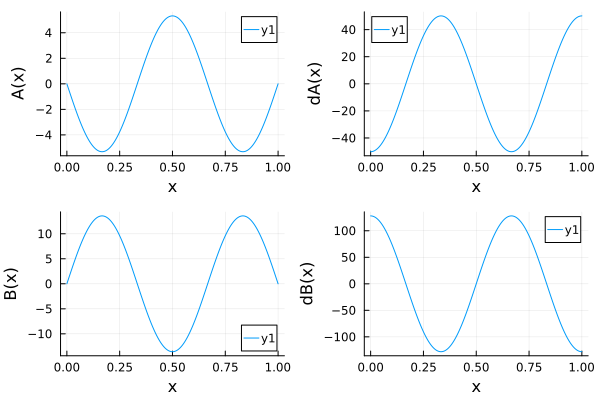

In [43]:
# plot u(x) and du/dx(x)
myA  = [u[1] for u in sol.u]
mydA = [u[2] for u in sol.u]
myB  = [u[3] for u in sol.u]
mydB = [u[4] for u in sol.u]
p1 = plot(sol.t, myA, xlabel="x", ylabel = "A(x)") 
p2 = plot(sol.t, mydA, xlabel="x", ylabel = "dA(x)") 
p3 = plot(sol.t, myB, xlabel="x", ylabel = "B(x)") 
p4 = plot(sol.t, mydB, xlabel="x", ylabel = "dB(x)")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 4.3:  Plot solution in space-time domain 

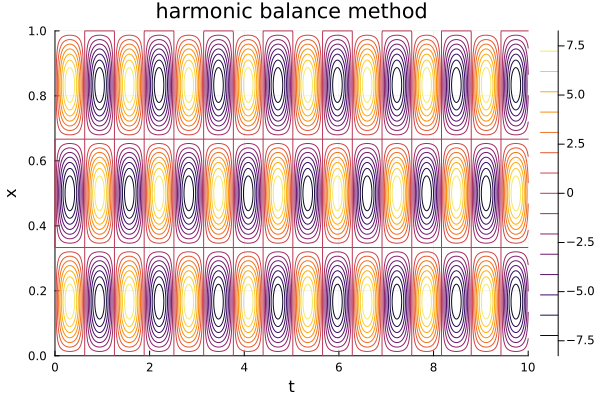

In [44]:
tend = 10; tstep = 0.01; 
tvec = 0:tstep:tend |> collect
ucost = sin.(omd*tvec); usint = sin.(omd*tvec)
U = myA*ucost' + myB*usint'
contour(tvec,sol.t,U,xlabel="t",ylabel="x",title="harmonic balance method")

### Section 6.3: Comparison with Transient Solution

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia 

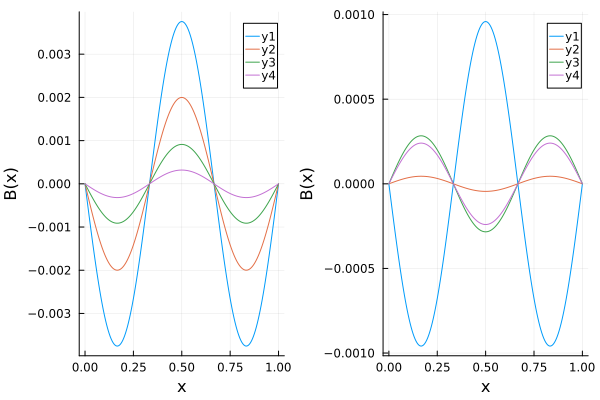

In [21]:
omdvec = [5.,10.,20.,40.]
myplta = plot();
mypltb = plot();
for omdi in omdvec
    p2 = [c, 50, gamma3, omdi]
    bvp = remake(bvp, p=p2);
    sol = solve(bvp, MIRK4(), dt = 0.005);
    myA  = [u[1] for u in sol.u]
    myB  = [u[3] for u in sol.u]
    myplta = plot!(myplta, sol.t, myA)
    mypltb = plot!(mypltb, sol.t, -myB)    
end 
plot(myplta, mypltb,xlabel="x", ylabel = "B(x)")

### Section 7.3: Comparison with Transient Solution 
Here we compare with transient time stepping. See [notebook on 1D scalar wave equations](./scalar-wave-equation.ipynb). 

Observe: 
1. a number of periods is required to reach steady-state;
1. the amplitude of the transient solution decreases over time;
1. even though a large number of time-periods is simulated, the effect of the boundary conditions imposed remains visible;   

<div>
<img src="./nonlin-scalar-wave-case2of3-transient.png" width=600 /> 
</div>

<div>
<img src="./nonlin-scalar-wave-case2of3-transient-zoom.png" width=600 /> 
</div>

In [45]:
# set source function 
# src(x) = 1000. # obtain u(x) > 1 for [u(x)}^3 to be large in size to be important in the non-linearity 
src(x) = 1000*sin(3*pi*x)

# set right-hand side 
function rhs!(du, u, p, x)
    c, gamma, gamma3, omd = p 
    A = u[1]; dA = u[2]; B = u[3]; dB = u[4]; 
    du[1] = dA
    # du[2] = -omd^2/c^2*A + gamma*omd/c^2*B - gamma3*(omd^3/c^2)*(0.75*B.^3 + 1.5*(A.^2).*B)
    du[2] = -omd^2/c^2*A + gamma*omd/c^2*B + gamma3*(omd^3/c^2)*(0.75*B.^3 + 1.5*(A.^2).*B)
    du[3] = dB
    du[4] = -omd^2/c^2*B - gamma*omd/c^2*A - gamma3*(omd^3/c^2)*(0.75*A.^3 + 1.5*(B.^2).*A) - src(x)/c^2 
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    Aleft = 0; Aright=0; 
    Bleft = 0; Bright=0; 
    residual[1] = u[1][1] - Aleft 
    residual[2] = u[end][1] - Aright
    residual[3] = u[1][3] - Bleft 
    residual[4] = u[end][3] - Bright
end

bc (generic function with 1 method)

In [56]:
# set constants 
c = 1.
gamma = 5 # 10. 
gamma3 = 5000. 
omd = 5
p = [c, gamma, gamma3, omd]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# store parameter value in p  
p = [c, gamma, gamma3, omd]
    
# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


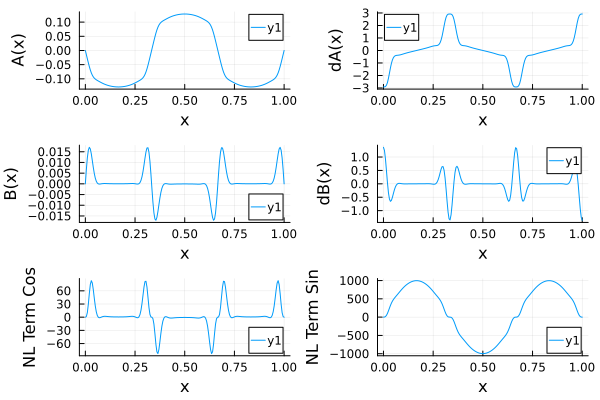

In [57]:
# plot u(x) and du/dx(x)
myA  = [u[1] for u in sol.u]
mydA = [u[2] for u in sol.u]
myB  = [u[3] for u in sol.u]
mydB = [u[4] for u in sol.u]
p1 = plot(sol.t, myA, xlabel="x", ylabel = "A(x)") 
p2 = plot(sol.t, mydA, xlabel="x", ylabel = "dA(x)") 
p3 = plot(sol.t, myB, xlabel="x", ylabel = "B(x)") 
p4 = plot(sol.t, mydB, xlabel="x", ylabel = "dB(x)")
p5 = plot(sol.t,   gamma3*(omd^3/c^2)*(0.75*myB.^3 + 1.5*(myA.^2).*myB), xlabel="x", ylabel = "NL Term Cos")
p6 = plot(sol.t, - gamma3*(omd^3/c^2)*(0.75*myA.^3 + 1.5*(myB.^2).*myA), xlabel="x", ylabel = "NL Term Sin")
plot(p1,p2,p3,p4,p5,p6,layout=(3,2))

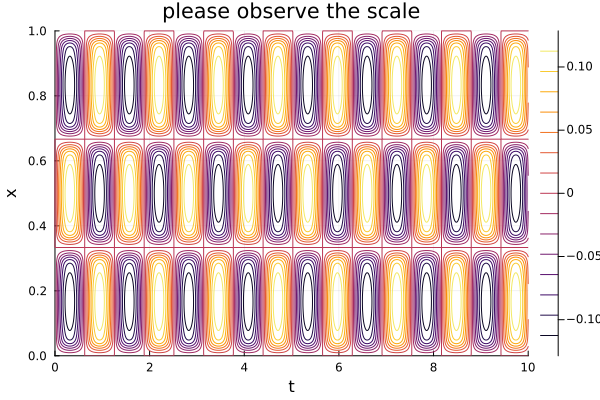

In [58]:
tend = 10; tstep = 0.01; 
tvec = 0:tstep:tend |> collect
ucost = sin.(omd*tvec); usint = sin.(omd*tvec)
U = myA*ucost' + myB*usint'
contour(tvec,sol.t,U,xlabel="t",ylabel="x", title="please observe the scale")

### Section 5.3: Comparison with Transient Solution

<div>
<img src="./nonlin-scalar-wave-case3of3-transient.png" width=600 /> 
</div>

<div>
<img src="./nonlin-scalar-wave-case3of3-transient-zoom.png" width=600 /> 
</div>